# Deep Learning Aproach to Binary Text Classification Task

In this notebook I explained how to retrain a pretrained deep learning classification model with a local text dataset. I used the model='distilbert-base-uncased' from hugging face platform. The model is retrained on a cyber security related text data and predicts the output as risky or not-risky classes.

## Text Classification with Birectional LSTM

In [4]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tensorflow as tf
# Text pre-processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# Train test split
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout,Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Lowercasing
train_df['text'] = train_df['content'].str.lower()
test_df['text'] = test_df['content'].str.lower()

# Remove special characters and digits
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
test_df['text'] = test_df['text'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Tokenization
train_df['text'] = train_df['text'].apply(lambda x: word_tokenize(x))
test_df['text'] = test_df['text'].apply(lambda x: word_tokenize(x))

# Remove stopwords
stop_words = set(stopwords.words('english'))
train_df['text'] = train_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
test_df['text'] = test_df['text'].apply(lambda x: [word for word in x if word not in stop_words])

# Stemming
stemmer = PorterStemmer()
train_df['text'] = train_df['text'].apply(lambda x: [stemmer.stem(word) for word in x])
test_df['text'] = test_df['text'].apply(lambda x: [stemmer.stem(word) for word in x])

# Join tokens back into sentences
train_df['text'] = train_df['text'].apply(lambda x: ' '.join(x))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join(x))

train_df = train_df[['text','environmental_issue']]
train_df = train_df.rename(columns = {'environmental_issue':'label'})

test_df = test_df[['text']]


# Split train dataset into train, val, and test sets
train_data, test_data = train_test_split(train_df, test_size=0.3, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=42)

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
X_train = tokenizer.texts_to_sequences(train_data['text'])
X_val = tokenizer.texts_to_sequences(val_data['text'])
X_test = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences to ensure uniform length
max_len = max([len(seq) for seq in X_train + X_val + X_test])
X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# Prepare labels
y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Bidirectional LSTM Model

Epoch 1/10
10/10 [==============================] - 19s 1s/step - loss: 0.6591 - accuracy: 0.6703 - val_loss: 0.5778 - val_accuracy: 0.8205
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 0.5710 - accuracy: 0.7692 - val_loss: 0.4711 - val_accuracy: 0.8205
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 0.5526 - accuracy: 0.7724 - val_loss: 0.4620 - val_accuracy: 0.8205
Epoch 4/10
10/10 [==============================] - 13s 1s/step - loss: 0.4866 - accuracy: 0.7692 - val_loss: 0.4640 - val_accuracy: 0.8205
Epoch 5/10
10/10 [==============================] - 14s 1s/step - loss: 0.4182 - accuracy: 0.8006 - val_loss: 0.3837 - val_accuracy: 0.8242
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.2819 - accuracy: 0.8791 - val_loss: 0.3786 - val_accuracy: 0.8095
Epoch 7/10
10/10 [==============================] - 13s 1s/step - loss: 0.2104 - accuracy: 0.9466 - val_loss: 0.5585 - val_accuracy: 0.8352
Epoch 8/10
10/10 [==

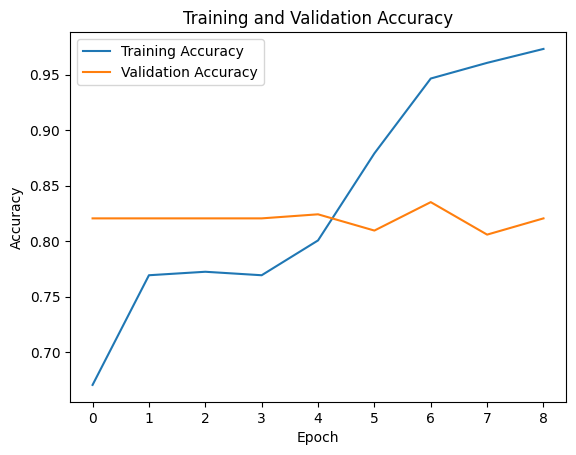

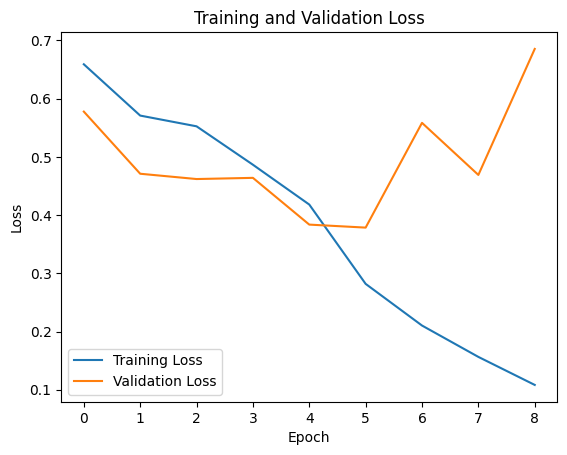

In [5]:
# Construct RNN model
model_biLSTM = Sequential()
model_biLSTM.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
model_biLSTM.add(Bidirectional(LSTM(50)))
model_biLSTM.add(Dense(64, activation='relu'))
model_biLSTM.add(tf.keras.layers.Dropout(0.3))
model_biLSTM.add(Dense(1, activation='sigmoid'))

# Compile the model
model_biLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model_biLSTM.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on test data
_, test_accuracy = model_biLSTM.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Plot graphs of accuracy and loss per epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [8]:
model_biLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 571, 100)          615300    
                                                                 
 bidirectional (Bidirection  (None, 100)               60400     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 682229 (2.60 MB)
Trainable params: 682229 (2.60 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

## Fine Tuning Distilbert Pretrained Model

In [6]:
# Load train.csv dataset
data = train_df

# Extract features and labels
X = data['text'].values
y = data['label'].values

# Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize text data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

# Convert encodings to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

# Define model configuration
model_dist = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Compile the model
model_dist.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model

model_dist.fit(train_dataset.shuffle(len(X_train)).batch(16),
          epochs=10,
          batch_size=16,
          validation_data=val_dataset.batch(16),
          callbacks=[early_stopping])

# Save the trained model
model_dist.save_pretrained('trained_distilbert_model')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
65/65 [==============================] - 109s 1s/step - loss: 0.8148 - accuracy: 0.6433 - val_loss: 0.6931 - val_accuracy: 0.7308
Epoch 2/10
65/65 [==============================] - 61s 937ms/step - loss: 0.6931 - accuracy: 0.7942 - val_loss: 0.6931 - val_accuracy: 0.7308
Epoch 3/10
65/65 [==============================] - 60s 931ms/step - loss: 0.6931 - accuracy: 0.7942 - val_loss: 0.6931 - val_accuracy: 0.7308
Epoch 4/10
65/65 [==============================] - 60s 932ms/step - loss: 0.6931 - accuracy: 0.7942 - val_loss: 0.6931 - val_accuracy: 0.7308


In [7]:
model_dist.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Conclusion

#### Both models overfit because their architecture is complex but the dataset is not large enough. To prevent from overfitting I added Dropout layer and early_stopping control mechanism to LSTM Model.